
*   [Survey 2022](https://www.sciencedirect.com/science/article/pii/S1051200422001312#br0120 ) (useful coz of short comments and pictures)
*   Best classification i found: [Yolov4 paper](https://arxiv.org/pdf/2004.10934.pdf)


## Dataset

In [ ]:
import torch
from torch import nn
import numpy as np
import torchvision
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (60,12)

In [ ]:
class VOC_Dataset(torch.utils.data.Dataset):
  def __init__(self, **kwargs):
    super().__init__()
    self._data = torchvision.datasets.VOCDetection(**kwargs)

    self.VOC_BBOX_LABEL_NAMES = (
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor')

  def _collate_anno(self, objects):
    """
    Parse xml to tensor.

    Input:
      objects: dict
    Return:
      bbox: torch.Tensor [N, 4]
      labels: list [N]
    """

    bbox = list()
    labels = list()
    for obj in objects:
      bbox_anno = obj['bndbox']
      bbox.append([int(bbox_anno[tag]) for tag in ('xmin', 'ymin', 'xmax', 'ymax')])

      name = obj['name'].lower().strip()
      labels.append(name) #VOC_BBOX_LABEL_NAMES.index(name)
      
    return torch.tensor(np.stack(bbox)), labels

  def __getitem__(self, idx):
    image_tensor, dict_anno = self._data[idx]
    bbox_tensor, labels = self._collate_anno(dict_anno['annotation']['object'])
    return {"image_tensor": image_tensor, "bbox_tensor": bbox_tensor, "labels": labels}

  def show(self, idx):
    sample = self.__getitem__(idx)
    viz = torchvision.utils.draw_bounding_boxes(sample["image_tensor"],
                                                sample["bbox_tensor"],
                                                sample["labels"],
                                                colors="red",
                                                width=2)
    plt.imshow((viz).permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.show()

  def __len__(self):
    return self._data.__len__()

In [ ]:
dataset = VOC_Dataset(root="/content",
                      year="2007",
                      image_set="train",
                      download=True,
                      transform=torchvision.transforms.PILToTensor())

  0%|          | 0/460032000 [00:00<?, ?it/s]

Extracting /content/VOCtrainval_06-Nov-2007.tar to /content


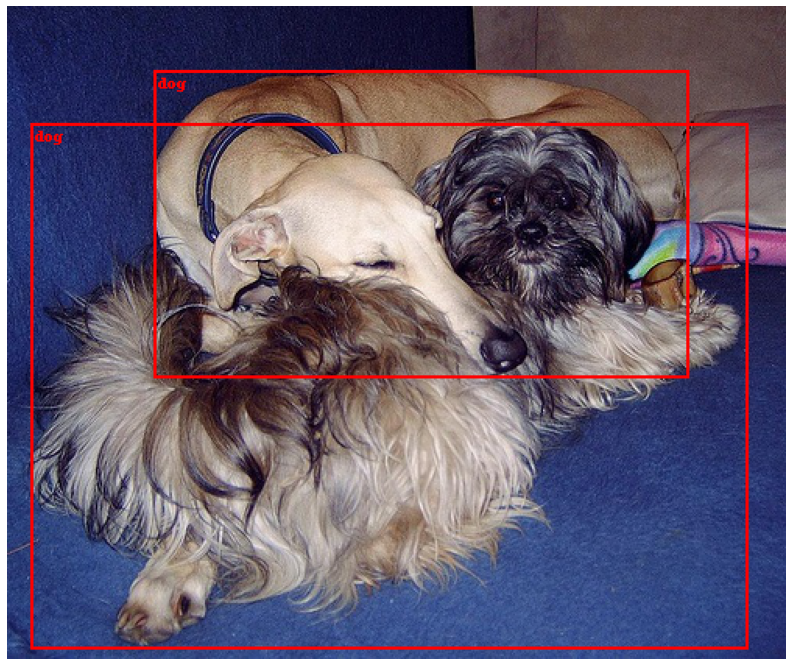

In [ ]:
dataset.show(18)

In [ ]:
dataset[18]["image_tensor"].shape

torch.Size([3, 419, 500])

## Two-stage anchor-based

https://www.geeksforgeeks.org/r-cnn-vs-fast-r-cnn-vs-faster-r-cnn-ml/

[Regions with CNN (R-CNN)](https://arxiv.org/abs/1311.2524
), 2014 -> [Fast R-CNN](https://arxiv.org/abs/1504.08083), 2015 -> [Faster R-CNN](https://arxiv.org/abs/1506.01497), 2016

### Faster R-CNN

![alt text](https://drive.google.com/uc?export=view&id=1MA-m4_PjWcXODzfHD-YKd3WulxoL87o-)

Разбор https://github.com/pytorch/vision/blob/main/torchvision/models/detection/faster_rcnn.py

Хорошая картинка, только backbone для https://drive.google.com/drive/folders/1RCOb5Ao3iXd2YwAMONBu9erwPTLf9FKP.

https://courses.grainger.illinois.edu/ECE417/fa2021/lectures/lec21.pdf

#### Backbone

In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
backbone = torchvision.models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT).features

In [ ]:
sample = dataset[18]["image_tensor"].float()
print(backbone(sample.unsqueeze(0)).shape)

torch.Size([1, 1280, 14, 16])


In [ ]:
backbone.out_channels = 1280

#### AnchorGenerator

https://github.com/pytorch/vision/blob/main/torchvision/models/detection/anchor_utils.py

In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

In [ ]:
def generate_anchors(sizes, aspect_ratios):
    """
     generate anchor template based on sizes and ratios, generated template is centered at [0, 0]
     :param sizes: anchor sizes, in tuple[int]
     :param aspect_ratios: anchor ratios, in tuple[float]
     :param dtype: data type
     :param device: data device
     :return:
     """

    sizes = torch.as_tensor(sizes)
    aspect_ratios = torch.as_tensor(aspect_ratios)
    h_ratios = torch.sqrt(aspect_ratios)
    w_ratios = 1.0 / h_ratios

    # [r1, r2, r3] * [s1, s2, s3]
    # number of elements is len(ratios)*len(sizes)
    ws = (w_ratios[:, None] * sizes[None, :]).view(-1)
    hs = (h_ratios[:, None] * sizes[None, :]).view(-1)

    # left-top, right-bottom coordinate relative to anchor center(0, 0)
    # anchor template is centered at [0, 0], shape [len(ratios)*len(scales), 4]
    base_anchors = torch.stack([-ws, -hs, ws, hs], dim=1) / 2

    return base_anchors.round()  # anchor will lose some precision here

In [ ]:
generate_anchors(sizes=(128, 256, 512), aspect_ratios=(0.5, 1.0, 2.0))

tensor([[ -91.,  -45.,   91.,   45.],
        [-181.,  -91.,  181.,   91.],
        [-362., -181.,  362.,  181.],
        [ -64.,  -64.,   64.,   64.],
        [-128., -128.,  128.,  128.],
        [-256., -256.,  256.,  256.],
        [ -45.,  -91.,   45.,   91.],
        [ -91., -181.,   91.,  181.],
        [-181., -362.,  181.,  362.]])

#### NMS

https://whatdhack.medium.com/reflections-on-non-maximum-suppression-nms-d2fce148ef0a  
https://paperswithcode.com/method/soft-nms  
https://github.com/DocF/Soft-NMS

**"We propose to revise the detection scores by scaling
them as a linear or Gaussian function of overlap"**

Обратите внимание на c++ реализацию оператора: https://github.com/MrParosk/soft_nms/tree/master/pt_soft_nms/csrc

In [ ]:
import time
import numpy as np
import torch


def soft_nms_pytorch(dets, box_scores, sigma=0.5, thresh=0.001, cuda=0):
    """
    Build a pytorch implement of Soft NMS algorithm.
    # Augments
        dets:        boxes coordinate tensor (format:[y1, x1, y2, x2])
        box_scores:  box score tensors
        sigma:       variance of Gaussian function
        thresh:      score thresh
        cuda:        CUDA flag
    # Return
        the index of the selected boxes
    """

    # Indexes concatenate boxes with the last column
    N = dets.shape[0]
    if cuda:
        indexes = torch.arange(0, N, dtype=torch.float).cuda().view(N, 1)
    else:
        indexes = torch.arange(0, N, dtype=torch.float).view(N, 1)
    dets = torch.cat((dets, indexes), dim=1)

    # The order of boxes coordinate is [y1,x1,y2,x2]
    y1 = dets[:, 0]
    x1 = dets[:, 1]
    y2 = dets[:, 2]
    x2 = dets[:, 3]
    scores = box_scores
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tscore = scores[i].clone()
        pos = i + 1

        if i != N - 1:
            maxscore, maxpos = torch.max(scores[pos:], dim=0)
            if tscore < maxscore:
                dets[i], dets[maxpos.item() + i + 1] = dets[maxpos.item() + i + 1].clone(), dets[i].clone()
                scores[i], scores[maxpos.item() + i + 1] = scores[maxpos.item() + i + 1].clone(), scores[i].clone()
                areas[i], areas[maxpos + i + 1] = areas[maxpos + i + 1].clone(), areas[i].clone()

        # IoU calculate
        yy1 = np.maximum(dets[i, 0].to("cpu").numpy(), dets[pos:, 0].to("cpu").numpy())
        xx1 = np.maximum(dets[i, 1].to("cpu").numpy(), dets[pos:, 1].to("cpu").numpy())
        yy2 = np.minimum(dets[i, 2].to("cpu").numpy(), dets[pos:, 2].to("cpu").numpy())
        xx2 = np.minimum(dets[i, 3].to("cpu").numpy(), dets[pos:, 3].to("cpu").numpy())
        
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = torch.tensor(w * h).cuda() if cuda else torch.tensor(w * h)
        ovr = torch.div(inter, (areas[i] + areas[pos:] - inter))

        # Gaussian decay
        weight = torch.exp(-(ovr * ovr) / sigma)
        scores[pos:] = weight * scores[pos:]

    # select the boxes and keep the corresponding indexes
    keep = dets[:, 4][scores > thresh].int()

    return keep


def speed():
    boxes = 1000*torch.rand((1000, 100, 4), dtype=torch.float)
    boxscores = torch.rand((1000, 100), dtype=torch.float)

    # cuda flag
    cuda = 1 if torch.cuda.is_available() else 0
    if cuda:
        boxes = boxes.cuda()
        boxscores = boxscores.cuda()

    start = time.time()
    for i in range(1000):
        soft_nms_pytorch(boxes[i], boxscores[i], cuda=cuda)
    end = time.time()
    print("Average run time: %f ms" % (end-start))


def test():
    # boxes and boxscores
    boxes = torch.tensor([[20, 20, 100, 100],
                          [50, 50, 150, 150],
                          [0, 0, 200, 200],
                          [600, 600, 700, 700]], dtype=torch.float)
    boxscores = torch.tensor([0.4, 0.5, 0.8, 0.5], dtype=torch.float)

    # cuda flag
    cuda = 1 if torch.cuda.is_available() else 0
    if cuda:
        boxes = boxes.cuda()
        boxscores = boxscores.cuda()

    print(soft_nms_pytorch(boxes, boxscores, cuda=cuda))


In [ ]:
test()

tensor([2, 3, 1, 0], dtype=torch.int32)


Дополнительно: https://stackoverflow.com/questions/55553747/what-is-scale-invariance-and-log-space-translations-of-a-bounding-box

**Домашнее задание:**

Обучить любой выбранный алгоритм детекции на VOC2007.
Нижняя граница метрики на тестовой выборке - **0.6 mAP**

## Two-stage anchor-free

**[1]** Ze Yang, Shaohui Liu, Han Hu, Liwei Wang, and Stephen
Lin. RepPoints: Point set representation for object detec-
tion. In Proceedings of the IEEE International Conference
on Computer Vision (ICCV), pages 9657–9666, 2019

**[2]** Piao, Zhengquan, et al. "AccLoc: Anchor-Free and two-stage detector for accurate object localization." Pattern Recognition 126 (2022): 108523.

## One-stage anchor-based

Разбор https://github.com/pytorch/vision/blob/main/torchvision/models/detection/ssd.py

## One-stage anchor-free

### FCOS: Fully Convolutional One-Stage Object Detection



*   https://paperswithcode.com/method/fcos
*   https://learnopencv.com/fcos-anchor-free-object-detection-explained/



Разбор https://github.com/pytorch/vision/blob/main/torchvision/models/detection/fcos.py

## SOTA (COCO)



[Group DETR v2](https://paperswithcode.com/paper/group-detr-v2-strong-object-detector-with-1)= ViT Encoder + [DETR.v=DINO](https://arxiv.org/abs/2203.03605) + [GroupDETR training](https://arxiv.org/abs/2207.13085)



Dino code: https://github.com/IDEA-Research/DINO

Original [DETR](https://arxiv.org/pdf/2005.12872.pdf) paper